# HACETTEPE UNIVERSITY 
## DEPARTMENT OF COMPUTER SCIENCE
## BBM 409 - FALL 2019
### ASSIGNMENT 3 - IMPLEMENTING NEURAL NETWORKS AND CNN TO CLASSIFY HERB IMAGES
* **NAME SURNAME: MERT ÇÖKELEK**
* **ID: 21727082**
* **DATE: 18.12.2019**

# PART I: Theory Questions
### Question 1

* **v = x1*w1 + x2*w2 + x3*w3** 
* **
* v = 3.x1 + (-5).x2 + 2.x3
* **
* **For Input 1:**
* v1 = 3 +0 +0 = 3, Y1 = 1
* **
* **For Input 2:**
* v2 = 0 +(-5) +2 = -3, Y2 = 0
* **
* **For Input 3:**
* v3 = 3 +0 +2 = 5, Y3 = 1
* **
* **For Input 4:**
* v4 = 3 +(-5) + 2 = 0, Y4 = 0
* ***
### Question 2
* **Weight Number in This Network:**
* **12**(Between Input-H1) **+7**(Between H2-H1) **+4**(Between Output-H2)
* **= 23**
* **
* **Weight Number for a Fully Connected Layer:** (# Nodes in Layer_n+1 X # Nodes in Layer_n) for every layer except output.
* **= ** 4x3 + 2x4 + 2x2**
* **= 24**
* **
* **Dependencies For Forward Propagation:**
* **1, 2, 3, 4:** Every Input nodes.
* **5:** Every Input nodes + **{1, 2, 3, 4}**
* **6:** Every Input nodes + **{1, 3, 4}**
* **7, 8:** Every Input nodes + **{1, 2, 3, 4}** + **{5, 6}**
* **
* **Dependencies For Backward Propagation:**
* **7, 8:** Every Output nodes.
* **5, 6:** Every Output nodes + **{7, 8}**
* **1, 3, 4:** Every Output nodes + **{7, 8}** + **{5, 6}**
* **2:** Every Output nodes + **{7, 8}** + **5**
* **
### Question 3
* **ADVANTAGE of FIRST ONE:**
* **Faster**, since the # of calculations are less.
* **
* **ADVANTAGE of SECOND ONE:**
* **More suitable for Complex Problems**, every hidden layer in the network changes the dimension of solution, better for non-linear and more complex problems.
* **
### Question 4
- A

* **Loss = L**
* dw5 = dL/dw5
* dw6 = dL/dw6
* dw1 = dL/dw5 * dw5/dw1
* dw2 = dL/dw6 * dw6/dw1


* **Yes, it becomes a linear model.** Because when q=1, in the two cases output takes continuous and partitioned as positive and negative classes.
* **
### Question 5
* **TRUE.** If a problem is linearly-separable, the suitable **line will eventually be generated** with parameter updates.
* **
* **FALSE.** XOR problem is **not linearly-separable**. Single perceptron can only solve linear-separable problems.
* **
* **FALSE.** The Learning Rate should start larger. Because the **loss curve** will have lesser **gradients**, after every epoch. **Lesser gradients and Lesser Learning Rate converges very slow.**
* **


# PART II: Classification of Herbs using Neural Network

## 1    Dataset
* The dataset contains 34225 herb images with total 683 classes.
#### **The Approach for Reading Dataset:**
* Take directory of the images from user.
* Sort the images by name to be able to match them with corresponding labels in csv file.
* Split the dataset into **Train (80%) and Test(20%) sets.**
* Convert the images into numpy arrays and resize them to a smaller size for fast execution.
* Merge the Train and Validation sets into seperate Pandas DataFrames.

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os

# READ THE DATA FROM OS DIRECTORY.
#C:\Users\100me\Desktop\train_resized\train_resized\
dir = input("Please enter the directory of the images.")
directory =dir
files = os.listdir(directory)
labels = pd.read_csv('Train_Info.csv')

# SORT THE IMAGE FILES BY NAME.
for i in range(len(files)):
    files[i] = files[i].split(".")[0]
files.sort(key=int)
for i in range(len(files)):
    files[i] = files[i] + ".jpg"

# # 80% TRAIN ; 20% TEST
train_size = 4 * labels.shape[0] // 5

# SPLIT THE DATA INTO TRAIN AND TEST.
train_files = files[:train_size]
test_files = files[train_size:]

# CONVERT IMAGES TO NUMPY ARRAYS.
x_Train = np.zeros((27380, 16*16))
for i in range(len(train_files)):
    img = np.array(Image.open(directory + train_files[i]).convert('L').resize((16, 16))) / 255.
    img = img.reshape(1, -1)
    x_Train[i] = img
    
x_Test = np.zeros((6845, 16*16))
for i in range(len(test_files)):
    img = np.array(Image.open(directory + test_files[i]).convert('L').resize((16,16))) / 255.
    img = img.reshape(1, -1)
    x_Test[i] = img
    
Train_DF = pd.DataFrame(x_Train, labels['Class'][:train_size])
Test_DF = pd.DataFrame(x_Test, labels['Class'][train_size:])

Please enter the directory of the images.C:\Users\100me\Desktop\train_resized\train_resized\


## 2    Multi Layer Neural Network
### HELPER FUNCTIONS
* Here are some helper functions for implementing a dynamic neural network.
### 2.1- Activation Functions
###### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Used for **forward propagation**, the activation input to a node (layer) is transformed to a different form.
* **To make the network non-linear.**

In [2]:
# ACTIVATION FUNCTIOSN
def sigmoid(Z):    
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0.001, Z)
    cache = Z 
    return A, cache

def tanh(Z):
    cache = Z
    A = np.tanh(Z)
    return A, cache

def softmax(a, axis=0):
    cache = a
    from scipy.special import logsumexp
    lse = logsumexp(a, axis=axis)  # this reduces along axis
    if axis is not None:
        lse = np.expand_dims(lse, axis)  # restore that axis for subtraction
    return np.exp(a - lse), cache

### 2.2- Initialize Parameters
* **
* Used at the beginning of the model.
* Arguments: **Layer Dimensions** (of form list **[Input_Layer_Nodes, Hidden_Layer_Nodes,Output_Layer_Nodes]**)
* **random**:Randomly initialize or initialize with zeros.
* **

In [3]:
# INITIALIZE PARAMETERS.
# If random == True, than weight and bias will be random.
# else, they will be initially 0.

def initialize_parameters(layer_dims, random=True):  
    np.random.seed(32)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    if random:
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    else:
        for l in range(1, L):
            parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

***
### 2.3- Forward Propagation
***
* After getting the parameters (weights), **there are 3 steps to make a forward-pass.**
* **1. linear_forward():** Simply returns Activation x Weight + Bias for that layer.
* **2. activation_forward():** Transforms the activation input from previous function into a non-linear form.
* **2.1.** Either 'relu, sigmoid, tanh, softmax'.
* **3. forward_propagate():** Calls the **activation_forward()** function for every single layer, starting from input to output, and returns a prediction.
***
#### Note: These functions also return 'caches', which are necessary for backward propagation. Gradient descent and parameter updates are depending on these caches. Caches hold weights, biases, activations.
***

In [4]:
def linear_forward(A, W, b):
    # For a layer, single step to propagate to next layer.
    # A := Activations from prev.layer.
    # W := Weights of that layer.
    # b := Bias that that layer.
    
    # Z := Outputs of the nodes in this layer.
    # cache := A, W, b. Stored for future backward prop. on this layer.

    Z = np.dot(W, A) + b
    cache = (A, W, b) 
    
    return Z, cache

def activation_forward(A_prev, W, b, activation):
    # For a layer, the output of the nodes are transformed with activation functions.
    # A_prev := Activations from prev. layer
    # W, b := Weight, bias of the layer
    # activation := activation function <sigmoid | tanh | relu | softmax>
    
    # A := activation(Z)
    # cache := linear cache - activation cache. For backward pass.
    
    if activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
        
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache

def forward_propagate(X, parameters, activate, output_activate):
    # L = Number of layers
    # X = input images
    # parameters: output of initialize_parameters()
    
    # AL: Last layer's activation values
    # caches: every cache of activation_forward()
    
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> ACTIVATE]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation=activate)
        caches.append(cache)
    
    # Create output. Add "cache" to the "caches" list.
    AL, cache = activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation=output_activate)  
    caches.append(cache)
            
    return AL, caches

***
### 2.4- Cost
***
* Used at the end of each forward pass.
* **Arguments:** Prediction and Ground-truth matrices.
* Calculates the loss (in this case **negative log-likelihood / cross_entropy**)
* Used for testing the model.

In [5]:
# LOSS FUNCTIONS.
def negative_log_likelihood(AL, Y):
        mul = Y * AL
        cost = np.sum(-np.log(mul[mul.nonzero()])) / AL.shape[1]
        return cost
    
def cross_entropy_loss(p, y):
    assert(p.shape == y.shape)
    m = p.shape[1]
    return (1./m) * (-np.sum(y * np.log(p)))

***
### 2.5- Backward Propagation
***
* Backward Propagation consists of 2 main steps.
* 1. Calculating Gradients.
* 2. Applying Gradient-Descent

* To calculate gradients, we need the derivatives of the activation functions.
***
#### 2.5.1- Derivatives of Activation Functions
***

In [6]:
############# DERIVATIVES FOR ACTIVATION FUNCTIONS #################
def sigmoid_backward(dA, cache):    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    
    return dZ

def tanh_backward(dA, cache):
    Z = cache
    t, _ = tanh(Z)
    dZ = dA * (1 - t**2)
    
    assert (dZ.shape == Z.shape)
    return dZ
def relu_backward(dA, cache):  
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0.001
    assert (dZ.shape == Z.shape)
    
    return dZ

def softmax_backward(dA, cache):
    Z = cache
    s, c = softmax(Z)
    dZ = dA * s * (1-s)
    return dZ

def Softmax_backward(dA, cache):
    Z = cache
    return dA

# Derivative of loss, w.r.t softmax function. Used at output-layer.
def grad_cross_entropy(p, y):
    return p - y

***
## So far, the forward-propagation and loss-calculation are done.
***
### Now, the model has to do backward-propagation (gradient descent, parameter updates) to increase accuracy and performance.

### 2.5- Backward Propagation
***
* After completing forward-pass, loss-calculation, **there are 3 steps to make a backward-pass.**
* **1. linear_backward():** Simply returns derivatives of loss with respect to that layer.
* **2. activation_backward():** Transforms the derivatives from previous function into the corresponding functions.
* **2.1.** Either 'relu, sigmoid, tanh, softmax'.
* **3. backward_propagate():** Calls the **activation_backward()** function for every single layer, starting from output to input, and returns the gradients of the layers, wrt loss.
***

In [7]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

def activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache) 
    elif activation == 'softmax':
        dZ = softmax_backward(dA, activation_cache)
    elif activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def backward_propagation(AL, Y, caches, activate, output_activate):
    grads = {};
    L = len(caches); # the number of layers
    m = AL.shape[1];
    Y = Y.reshape(AL.shape);

    # Initializing the backpropagation
    dAL = grad_cross_entropy(AL, Y)
    
    dA_prev, dW, db = activation_backward(dAL, caches[L - 1], output_activate);
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db;

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 1)], current_cache, activate)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads;

***
#### The gradients are calculated in the previous step, now update the parameters(weights) using Gradient-Descent
***

In [8]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2       # number of layers in the neural network

    # For every layer, gradient descent.
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)];
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)];
    return parameters;

***
### All the helper functions are defined.
### Now, it's time to use them in our 'Model'.
***

In [9]:
import matplotlib.pyplot as plt
def Model(trainDF, testDF, layerDims, batch_size, learning_rate, epochs, activate, output_activate, random_initialize):
    np.random.seed(26)
    costs1 = []                         # Train costs
    costs2 = []                         # Test costs
    
    # Parameters initialization.
    parameters = initialize_parameters(layerDims);

    # LOOP (FORWARD -> LOSS -> BACKWARD -> FORWARD ...)
    
    # Number of batches
    batch_train = int(trainDF.shape[0] / batch_size)
    batch_test = int(testDF.shape[0] / batch_size)
    for epoch in range(epochs):
        total_train_loss = 0
        total_test_loss = 0
        
        prev_train_batch = 0
        prev_test_batch = 0
        
        for batch in range(batch_test):
            test = testDF[prev_test_batch: prev_test_batch + batch_size]
            prev_test_batch += batch_size
            xtest = test.T.values
            ytest = test.index.values
            ytest = np.eye(683)[ytest.squeeze()].T
        
            AL2, caches2 = forward_propagate(xtest, parameters, activate, 'softmax')         # Predictions for Test samples
            cost2 =  negative_log_likelihood(AL2, ytest)                         # Loss for Test samples.
            total_test_loss += cost2
            
        for batch in range(batch_train):
            train = trainDF[prev_train_batch: prev_train_batch + batch_size]
            prev_train_batch += batch_size
            xtrain = train.T.values
            ytrain = train.index.values
            ytrain = np.eye(683)[ytrain.squeeze()].T
            
            AL1, caches1 = forward_propagate(xtrain, parameters, activate, 'softmax')        # Forward propagation
            cost1 = negative_log_likelihood(AL1, ytrain)                          # Compute loss for Train
            total_train_loss += cost1
            grads = backward_propagation(AL1, ytrain, caches1, activate, output_activate)          # Backward propagation, w.r.t Train.
            parameters = update_parameters(parameters, grads, learning_rate)      # Update parameters.


        total_train_loss /= (27380) # Train size
        total_test_loss /= (6485)   # Test size
        total_train_loss *= (100) # Train size
        total_test_loss *= (100)   # Test size
        print("Epoch: ", epoch, "\tTrainLoss: ", total_train_loss, "\tTestLoss: ", total_test_loss)
        costs1.append(total_train_loss)
        costs2.append(total_test_loss)
        
        Costs = [costs1, costs2]
    return Costs, parameters

In [10]:
def plot(loss, batch_size, lr, col):
    plt.plot(np.squeeze(loss),  color =col)
    if(col == 'orange'):
        plt.ylabel('Train Loss')
    else:
        plt.ylabel('Test Loss')
    plt.xlabel('Epoch')
    plt.title("      Batch Size: %d, Learning Rate: %s." % (batch_size, lr))
    
    plt.show()
    
def model(traindf, testdf, layerdimensions, batch_sz, lr, epochs, activation, output_activation, init_random):
    loss, params = Model(traindf, testdf, layerdimensions, batch_sz, float(lr), epochs, activation, output_activation, init_random)
    plot(loss[0], batch_sz, lr, 'orange')
    plot(loss[1], batch_sz, lr, 'blue')
    
    # Calculate accuracy for train set.
    xtrain = traindf.T.values
    ytrain = traindf.index.values
    ytrain = np.eye(683)[ytrain.squeeze()].T
    
    # Calculate accuracy for validation set.
    xtest = testdf.T.values
    ytest = testdf.index.values
    ytest = np.eye(683)[ytest.squeeze()].T
    
    predictions1, _ = forward_propagate(xtest, params, activation, output_activation)
    test_correct_preds = np.intersect1d(predictions1.argmax(axis=1), ytest.argmax(axis=1)).size
    test_accuracy = 100 * test_correct_preds / 6845
    
    predictions2, _ = forward_propagate(xtrain, params, activation, output_activation)
    train_correct_preds = np.intersect1d(predictions2.argmax(axis=1), ytrain.argmax(axis=1)).size
    train_accuracy = 100 * train_correct_preds / 27380
    
    return loss, train_accuracy, test_accuracy

# ANALYSIS OF MODEL
## 1. Plotting Train-Test Losses.
***


* First, let's use different combinations of activation functions.
***
### 1- Output Activation: Sigmoid
* Sigmoid is mostly used for **binary classification**, let's analyze its performance on **683** classes.
* **BLUE LINES: TEST LOSS**
* **ORANGE LINES: TRAIN LOSS**

Epoch:  0 	TrainLoss:  0.6435975206574446 	TestLoss:  0.6038402124407404
Epoch:  1 	TrainLoss:  0.6435849481844037 	TestLoss:  0.60384472794764
Epoch:  2 	TrainLoss:  0.6435723805521879 	TestLoss:  0.6038492251357543
Epoch:  3 	TrainLoss:  0.6435597876274674 	TestLoss:  0.6038537132311276
Epoch:  4 	TrainLoss:  0.6435471699964889 	TestLoss:  0.6038582399382243
Epoch:  5 	TrainLoss:  0.643534545900316 	TestLoss:  0.6038628012715392
Epoch:  6 	TrainLoss:  0.6435219377023724 	TestLoss:  0.6038673703092755
Epoch:  7 	TrainLoss:  0.6435093563362209 	TestLoss:  0.6038719485590762
Epoch:  8 	TrainLoss:  0.6434967979466496 	TestLoss:  0.6038765307480092
Epoch:  9 	TrainLoss:  0.6434842436322149 	TestLoss:  0.6038811140729519


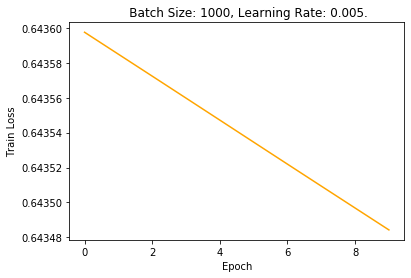

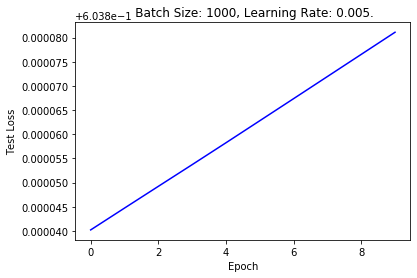

In [11]:
Layers1 = [16*16, 128, 64, 683]
batchSize1 = 1000
activation1 = 'relu'
output_activation1 = 'sigmoid'
LR = str(0.005)
loss1, trainacc1, testacc1= model(Train_DF, Test_DF, Layers1, batchSize1, LR, 10,  activation1, output_activation1, True)

* As seen, the train loss decreased but test loss increased dramatically.
* **So, sigmoid is not a good choice.**
### Why?
* **Because Sigmoid implies '0' and '1' results for extreme points.**
* This is a **bad** situation **for 683 classes.**

### 2- Output Activation: Softmax
* Softmax is mostly used for **multi-class classification**, let's analyze its performance on **683** classes.
* **BLUE LINES: TEST LOSS**
* **ORANGE LINES: TRAIN LOSS**
#### 2.1- With 'tanh' activations

Epoch:  0 	TrainLoss:  0.6435914567751894 	TestLoss:  0.6038367050574333
Epoch:  1 	TrainLoss:  0.6435913816678498 	TestLoss:  0.603836732380627
Epoch:  2 	TrainLoss:  0.6435913065603823 	TestLoss:  0.6038367597038496
Epoch:  3 	TrainLoss:  0.6435912314527867 	TestLoss:  0.6038367870271013
Epoch:  4 	TrainLoss:  0.6435911563450634 	TestLoss:  0.6038368143503817
Epoch:  5 	TrainLoss:  0.6435910812372113 	TestLoss:  0.6038368416736914
Epoch:  6 	TrainLoss:  0.6435910061292316 	TestLoss:  0.60383686899703
Epoch:  7 	TrainLoss:  0.6435909310211241 	TestLoss:  0.6038368963203975
Epoch:  8 	TrainLoss:  0.6435908559128882 	TestLoss:  0.6038369236437942
Epoch:  9 	TrainLoss:  0.6435907808045244 	TestLoss:  0.6038369509672197


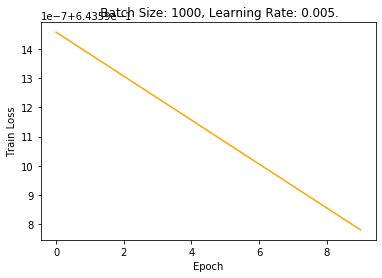

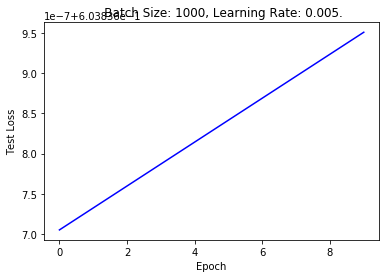

In [12]:
Layers2 = [16*16, 128, 64, 683]
batchSize2 = 1000
activation2 = 'tanh'
output_activation2 = 'softmax'
LR = str(0.005)
loss2, trainacc2, testacc2= model(Train_DF, Test_DF, Layers2, batchSize2, LR, 10,  activation2, output_activation2, True)

* Even if we used **Softmax**, it is still not a good model.
* The problem is not with **Softmax**, it is about **tanh**.
* Because **tanh** is just like **sigmoid**, it takes **binary values in extremum points**, which is useless for **multi-class classification.** 
***

#### 2.2- With 'ReLU' activations:
* **RelU** seems to be a **good choice for multi-class** classification.
* Because it does not take limited values **in extreme cases**, and it **is non-linear**.
* **BLUE LINES: TEST LOSS**
* **ORANGE LINES: TRAIN LOSS**

Epoch:  0 	TrainLoss:  0.643596109463105 	TestLoss:  0.6038402124407404
Epoch:  1 	TrainLoss:  0.6435960287782512 	TestLoss:  0.60384017189222
Epoch:  2 	TrainLoss:  0.6435959481364673 	TestLoss:  0.6038401164827979
Epoch:  3 	TrainLoss:  0.643595837817648 	TestLoss:  0.6038400552061128
Epoch:  4 	TrainLoss:  0.6435957038398552 	TestLoss:  0.6038400355595637
Epoch:  5 	TrainLoss:  0.6435955613196532 	TestLoss:  0.6038400508285171
Epoch:  6 	TrainLoss:  0.6435954311350061 	TestLoss:  0.6038400694788633
Epoch:  7 	TrainLoss:  0.6435953231659552 	TestLoss:  0.6038400930702632
Epoch:  8 	TrainLoss:  0.6435952331280151 	TestLoss:  0.6038401198037873
Epoch:  9 	TrainLoss:  0.6435951499940283 	TestLoss:  0.6038401470585806


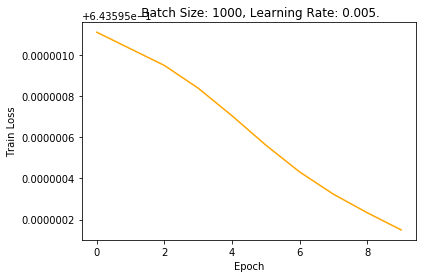

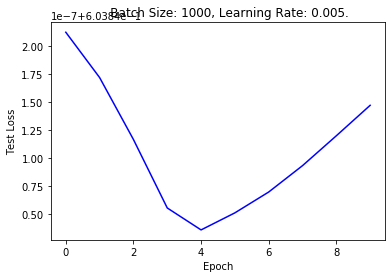

In [13]:
Layers = [16*16, 128, 64, 683]
batchSize = 1000
activation = 'relu'
output_activation = 'softmax'
LR = 0.005
loss, trainacc, testacc= model(Train_DF, Test_DF, Layers, batchSize, LR, 10,  activation, output_activation, True)

### Bingo!
***
* With using **ReLU** as activation function **in hidden layers**, and **softmax in output** layer;
* **Train Loss decreases by every iteration/epoch.**
* **Test Loss First decreases, then increases.**
* **The increase in test loss** is something **we want**, because the point of **minima of the curve** shows us the **perfect point to stop training.**.
* For example at epoch 4, we can stop training and start to make predictions.
***
## These plots were only a hint, on choosing the appropriate model.
* We learned that we **shouldn't use** activation functions as **tanh, sigmoid**.
* The optimum model should contain **ReLU** in hidden layers and **Softmax** in output layer.

***
## Now, let's discover the effects of hyperparameters on the 'ReLU - Softmax' model.
### Hyperparameters:
#### Learning Rate, Number of Epochs, Batch Size
***

In [72]:
Learning_Rates = [0.005, 0.01, 0.25]
BatchSizes = [32, 512]
Layer_Dimensions_2D = [[256, 32, 16, 683], [256, 512, 256, 683]]

In [73]:
def create_table_of_hyperparameters(traindf, testdf,layer_dimensions, learning_rates, number_of_epochs, batch_sizes):
    Losses_WRT_Hyperparameters = dict()
    i = 0
    for layerdimensions in layer_dimensions:
        for learning_rate in Learning_Rates:
            for batch_size in BatchSizes:
                print(i, "-------------")
                i+=1
                loss,_ = Model(traindf, testdf, layerdimensions, batch_size, learning_rate, 10, 'relu', 'softmax', True)
                hptrain = str(layerdimensions) +" "+ str(learning_rate)  +" "+  str(10)  +" "+ str(batch_size)  +" "+  "Train Loss"
                hptest = str(layerdimensions) +" "+ str(learning_rate)  +" "+  str(10)  +" "+ str(batch_size)  +" "+  "Test Loss"
                trainloss = loss[0]
                testloss = loss[1]
                Losses_WRT_Hyperparameters[hptrain] = min(trainloss)
                Losses_WRT_Hyperparameters[hptest] = min(testloss)
    return Losses_WRT_Hyperparameters

* **Approach:** 
* Create 3 different arrays for the hyperparameters
* Make a **3.degree for loop** and **calculate** every single **losses for train and test**.
* **
### 1. Neural Network with 2 Hidden Layers
* **OUTPUT FORMAT:**
* Python Dictionary of format **{ [ Layer Dimension, Learning Rate, Batch Size ], Accuracy }**

In [74]:
Losses_2D =create_table_of_hyperparameters(Train_DF, Test_DF, Layer_Dimensions_2D, Learning_Rates, NumberOfEpochs, BatchSizes)

0 -------------
Epoch:  0 	TrainLoss:  20.380382238508645 	TestLoss:  21.436405659966944
Epoch:  1 	TrainLoss:  20.38030911027853 	TestLoss:  21.436437302950935
Epoch:  2 	TrainLoss:  20.38023702468574 	TestLoss:  21.436469916869612
Epoch:  3 	TrainLoss:  20.380166604625373 	TestLoss:  21.436511492803813
Epoch:  4 	TrainLoss:  20.38009558745505 	TestLoss:  21.436556023788896
Epoch:  5 	TrainLoss:  20.380025728000163 	TestLoss:  21.43660402397202
Epoch:  6 	TrainLoss:  20.379957732640904 	TestLoss:  21.436653251119456
Epoch:  7 	TrainLoss:  20.379895399912954 	TestLoss:  21.436712337011354
Epoch:  8 	TrainLoss:  20.379826562376007 	TestLoss:  21.436767823252133
Epoch:  9 	TrainLoss:  20.379758308545114 	TestLoss:  21.436826657591794
1 -------------
Epoch:  0 	TrainLoss:  1.2633468658337077 	TestLoss:  1.3083250915628744
Epoch:  1 	TrainLoss:  1.2633465252354101 	TestLoss:  1.3083252273319004
Epoch:  2 	TrainLoss:  1.2633461731297844 	TestLoss:  1.3083252772648273
Epoch:  3 	TrainLoss:  

### 2. Neural Network with 1 Hidden Layer
* **OUTPUT FORMAT:**
* Python Dictionary of format **{ [ Layer Dimension, Learning Rate, Batch Size ], Accuracy }**

In [98]:
Layer_Dimensions_1D = [[256, 32, 683], [256, 256, 683]]
Losses_1D =create_table_of_hyperparameters(Train_DF, Test_DF, Layer_Dimensions_1D, Learning_Rates, NumberOfEpochs, BatchSizes)

0 -------------
Epoch:  0 	TrainLoss:  20.38050122634448 	TestLoss:  21.436183843903574
Epoch:  1 	TrainLoss:  20.38026455966095 	TestLoss:  21.436412973557537
Epoch:  2 	TrainLoss:  20.380036600737313 	TestLoss:  21.43678680589219
Epoch:  3 	TrainLoss:  20.379770987874217 	TestLoss:  21.43695614157524
Epoch:  4 	TrainLoss:  20.379613246204354 	TestLoss:  21.437144395751616
Epoch:  5 	TrainLoss:  20.379519673525518 	TestLoss:  21.437137637344136
Epoch:  6 	TrainLoss:  20.379423763398602 	TestLoss:  21.437120601038963
Epoch:  7 	TrainLoss:  20.379320131836852 	TestLoss:  21.437083516120975
Epoch:  8 	TrainLoss:  20.379194141412622 	TestLoss:  21.437000867554776
Epoch:  9 	TrainLoss:  20.378996381842935 	TestLoss:  21.43667072342474
1 -------------
Epoch:  0 	TrainLoss:  1.26334786910956 	TestLoss:  1.3083144013977601
Epoch:  1 	TrainLoss:  1.2633481344054378 	TestLoss:  1.3083204487851208
Epoch:  2 	TrainLoss:  1.2633496731706313 	TestLoss:  1.3083230473146104
Epoch:  3 	TrainLoss:  1.2

In [101]:
Layer_Dimensions_0D = [[256, 683], [256, 683]]
Losses_0D =create_table_of_hyperparameters(Train_DF, Test_DF, Layer_Dimensions_0D, Learning_Rates, NumberOfEpochs, BatchSizes)

0 -------------
Epoch:  0 	TrainLoss:  20.36629070610014 	TestLoss:  21.55287381376315
Epoch:  1 	TrainLoss:  20.35567819273435 	TestLoss:  21.55719979568568
Epoch:  2 	TrainLoss:  20.344988564261982 	TestLoss:  21.56154697363508
Epoch:  3 	TrainLoss:  20.33421998787277 	TestLoss:  21.565916262430672
Epoch:  4 	TrainLoss:  20.32337057159794 	TestLoss:  21.570308627762365
Epoch:  5 	TrainLoss:  20.312438362362613 	TestLoss:  21.5747250901554
Epoch:  6 	TrainLoss:  20.301421344053168 	TestLoss:  21.579166729312725
Epoch:  7 	TrainLoss:  20.29031743562105 	TestLoss:  21.583634688877265
Epoch:  8 	TrainLoss:  20.279124489248805 	TestLoss:  21.588130181661214
Epoch:  9 	TrainLoss:  20.2678402886097 	TestLoss:  21.592654495395468
1 -------------
Epoch:  0 	TrainLoss:  1.2627545632006818 	TestLoss:  1.3154830221284093
Epoch:  1 	TrainLoss:  1.2627132177021663 	TestLoss:  1.315499536945043
Epoch:  2 	TrainLoss:  1.2626718538521844 	TestLoss:  1.3155160566695454
Epoch:  3 	TrainLoss:  1.2626304

In [117]:
print("  Layer Dimension | LR | BatchSize, epoch| Loss")
Losses_0D

  Layer Dimension | LR | BatchSize, epoch| Loss


{'[256, 683] 0.005 10 32 Train Loss': 20.2678402886097,
 '[256, 683] 0.005 10 32 Test Loss': 21.55287381376315,
 '[256, 683] 0.005 10 512 Train Loss': 1.2623817908171597,
 '[256, 683] 0.005 10 512 Test Loss': 1.3154830221284093,
 '[256, 683] 0.01 10 32 Train Loss': 20.15728952215035,
 '[256, 683] 0.01 10 32 Test Loss': 21.55287381376315,
 '[256, 683] 0.01 10 512 Train Loss': 1.262010937798264,
 '[256, 683] 0.01 10 512 Test Loss': 1.3154830221284093,
 '[256, 683] 0.25 10 32 Train Loss': 17.95521662834031,
 '[256, 683] 0.25 10 32 Test Loss': 21.55287381376315,
 '[256, 683] 0.25 10 512 Train Loss': 1.2425860402248017,
 '[256, 683] 0.25 10 512 Test Loss': 1.3154830221284093}

In [118]:
print("  Layer Dimension | LR | BatchSize, epoch| Loss")
Losses_1D

  Layer Dimension | LR | BatchSize, epoch| Loss


{'[256, 32, 683] 0.005 10 32 Train Loss': 20.378996381842935,
 '[256, 32, 683] 0.005 10 32 Test Loss': 21.436183843903574,
 '[256, 32, 683] 0.005 10 512 Train Loss': 1.2633454404393532,
 '[256, 32, 683] 0.005 10 512 Test Loss': 1.3083144013977601,
 '[256, 32, 683] 0.01 10 32 Train Loss': 20.378275318280526,
 '[256, 32, 683] 0.01 10 32 Test Loss': 21.436183843903574,
 '[256, 32, 683] 0.01 10 512 Train Loss': 1.2633380206866145,
 '[256, 32, 683] 0.01 10 512 Test Loss': 1.3083144013977601,
 '[256, 32, 683] 0.25 10 32 Train Loss': 20.270619966988026,
 '[256, 32, 683] 0.25 10 32 Test Loss': 21.436183843903574,
 '[256, 32, 683] 0.25 10 512 Train Loss': 1.2631566770985068,
 '[256, 32, 683] 0.25 10 512 Test Loss': 1.3083144013977601,
 '[256, 256, 683] 0.005 10 32 Train Loss': 20.380422839738515,
 '[256, 256, 683] 0.005 10 32 Test Loss': 21.43123997781088,
 '[256, 256, 683] 0.005 10 512 Train Loss': 1.263569582449897,
 '[256, 256, 683] 0.005 10 512 Test Loss': 1.3080318539940672,
 '[256, 256, 6

In [119]:
print("  Layer Dimension | LR | BatchSize, epoch| Loss")
Losses_2D

  Layer Dimension | LR | BatchSize, epoch| Loss


{'[256, 32, 16, 683] 0.005 10 32 Train Loss': 20.379758308545114,
 '[256, 32, 16, 683] 0.005 10 32 Test Loss': 21.436405659966944,
 '[256, 32, 16, 683] 0.005 10 512 Train Loss': 1.2633441724476422,
 '[256, 32, 16, 683] 0.005 10 512 Test Loss': 1.3083250915628744,
 '[256, 32, 16, 683] 0.01 10 32 Train Loss': 20.379148784767192,
 '[256, 32, 16, 683] 0.01 10 32 Test Loss': 21.436405659966944,
 '[256, 32, 16, 683] 0.01 10 512 Train Loss': 1.2633415938317891,
 '[256, 32, 16, 683] 0.01 10 512 Test Loss': 1.3083250915628744,
 '[256, 32, 16, 683] 0.25 10 32 Train Loss': 0.0,
 '[256, 32, 16, 683] 0.25 10 32 Test Loss': 0.0,
 '[256, 32, 16, 683] 0.25 10 512 Train Loss': 1.2632269148498017,
 '[256, 32, 16, 683] 0.25 10 512 Test Loss': 1.3083250915628744,
 '[256, 512, 256, 683] 0.005 10 32 Train Loss': 20.03002417503015,
 '[256, 512, 256, 683] 0.005 10 32 Test Loss': 21.43734330244646,
 '[256, 512, 256, 683] 0.005 10 512 Train Loss': 1.2633008045868463,
 '[256, 512, 256, 683] 0.005 10 512 Test Los

### Conclusion on Neural Network with no Hidden Layer:
* Increasing **the neuron number in hidden layers** did notwork for this network.
* This **maybe** because **the model is underfitting or not complex enough** to solve the problem.
* The **losses are high,** so **I tried with** Neural Network **with 1 Hidden Layer**.

### Conclusion on Neural Network with 1 Hidden Layer:
* Increasing **the neuron number in hidden layers** did sometimes worked for this network.
* This **maybe** because **the model is not overfitting, it needs tuning** to solve the problem.
* But the **losses are smaller**, so the **1 Layer-Model is better than 2-Layer Model**. for this dataset.

### Conclusion on Neural Network with 2 Hidden Layers:
* Increasing **the neuron number in hidden layers** did not work in this case.
* This **maybe** because **the model is already complex enough** to solve the problem.
* But the **losses are not small**, so the **model is not good**.

## Conclusions on General Neural Network:
* The **loss is high**, number of **correct predicions are low.**
* Accucacy did not go furher **3%**.
* This maybe because the **dataset is noisy.**
* There are **so many classes** but **not enough instances** for the classes.

### A Neural Network did not do well on this dataset, so now let's try to classify with Convolutional Neural Network.


## 3 Convolutional Neural Network
***
### 1 Read Input


In [122]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

cuda = torch.device('cuda')

# Read Input Files
Files = os.listdir(dir)
Labels = pd.read_csv('Train_Info.csv')

for i in range(len(Files)):
    Files[i] = Files[i].split(".")[0]
Files.sort(key=int)
for i in range(len(Files)):
    Files[i] = Files[i] + ".jpg"

Labels_shuffled = Labels['Id'].sample(frac=1)
Files_shuffled = np.array(Files)

# X = all data, m = # of examples
X = np.zeros((34225, 32*32))
m = (Labels.shape[0])
for i in range(m):
    img = np.array(Image.open(dir + Files[i]).convert('L').resize((32, 32))) / 255.
    img = img.reshape(1, -1)
    X[i] = img
Y = Labels['Class'][Labels_shuffled]

# Create numpy arrays
lenTrain = int(4 * (X.shape[0] / 5))
x_Train = X[:lenTrain]
y_Train = Y[:lenTrain]
x_Test = X[lenTrain:]
y_Test = Y[lenTrain:]

### 1.1 Create a DataFrame to see the input

In [123]:
# This takes approx. 3-4 minutes since dataset is large.
df_Train = pd.DataFrame(x_Train, y_Train)
df_Test  = pd.DataFrame(x_Test, y_Test)

In [147]:
df_Train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Class,,,,,,,,,,,,,,,,,,,,,
356,0.090196,0.454902,0.121569,0.145098,0.137255,0.090196,0.149020,0.101961,0.219608,0.286275,...,0.015686,0.011765,0.007843,0.011765,0.007843,0.000000,0.000000,0.000000,0.015686,0.007843
443,0.043137,0.168627,0.062745,0.113725,0.133333,0.121569,0.168627,0.176471,0.184314,0.090196,...,0.007843,0.003922,0.007843,0.007843,0.003922,0.007843,0.011765,0.000000,0.019608,0.007843
256,0.015686,0.309804,0.058824,0.149020,0.098039,0.176471,0.286275,0.380392,0.254902,0.090196,...,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922,0.000000,0.007843,0.007843
97,0.000000,0.400000,0.117647,0.125490,0.074510,0.090196,0.156863,0.168627,0.247059,0.156863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
655,0.278431,0.192157,0.101961,0.090196,0.117647,0.152941,0.137255,0.172549,0.254902,0.345098,...,0.078431,0.015686,0.035294,0.039216,0.039216,0.039216,0.035294,0.031373,0.023529,0.003922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.156863,0.078431,0.321569,0.164706,0.180392,0.164706,0.149020,0.200000,0.180392,0.184314,...,0.043137,0.039216,0.027451,0.023529,0.039216,0.047059,0.035294,0.027451,0.043137,0.070588
355,0.000000,0.078431,0.180392,0.152941,0.141176,0.133333,0.113725,0.074510,0.043137,0.050980,...,0.007843,0.007843,0.007843,0.007843,0.003922,0.003922,0.000000,0.023529,0.000000,0.035294
670,0.003922,0.054902,0.113725,0.101961,0.098039,0.094118,0.082353,0.047059,0.027451,0.011765,...,0.027451,0.031373,0.035294,0.035294,0.035294,0.035294,0.039216,0.027451,0.011765,0.000000


### 2 PyTorch Custom Dataset and Dataloader Implementation
#### 2.1 Dataset Class
***

In [124]:
# DATASET CREATION
class Herbarium_Dataset(Dataset):
    def __init__(self, Dataframe):
        self.dataframe = Dataframe
        self.labels = self.dataframe.index
        
    def __len__(self):
        return len(self.dataframe.index)

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        img_as_np = self.dataframe.iloc[index].values.reshape(1, 32, 32)
        img_as_tensor = torch.tensor(img_as_np).float().cuda()
        return(img_as_tensor, single_image_label)

#### 2.2 Dataloader Implementation

In [125]:
# DATALODER
train_set = Herbarium_Dataset(df_Train)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=False)

* **See a sample image from dataset to check if the images are taken correctly.**

Label: 356
torch.Size([1, 32, 32])


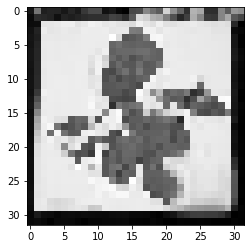

In [126]:
# Show a sample picture-label pair, to see if the data is taken correctly.
# Sometimes the image is not shown.
# In that case, please re-run this cell.

sample = next(iter(train_set))
image, label = sample
import matplotlib.pyplot as plt
print("Label:", label)
print(image.shape)
imsq = image.squeeze()
plt.imshow(imsq.cpu(), cmap='gray')

* **Now let's see a sample image batch.**

2
torch.Size([10, 1, 32, 32]) torch.Size([10])
labels: tensor([356, 443, 256,  97, 655, 514, 495, 315,  14,  94])


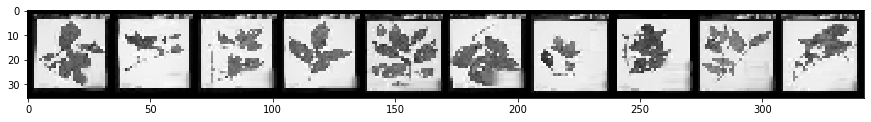

In [127]:
# See a sample batch
batch = next(iter(train_loader))
print(len(batch))
images, labels = batch
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
print("labels:", labels)

In [128]:
def number_of_correct_predictions(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### 3 Creating a CNN with 1 Convolutional and 1 Fully Connected Layer
***

In [133]:
import torch.nn as nn
import torch.nn.functional as F

class Network_1D(nn.Module):
    def __init__(self, outChannels, kernelSize):
        super(Network_1D, self).__init__()
        self.sz = 32
        self.outChannels = outChannels
        self.conv = nn.Conv2d(in_channels=1, out_channels=outChannels, kernel_size=kernelSize)
        self.sz = int((self.sz - kernelSize + 1) / 2)
        self.fc = nn.Linear(in_features=outChannels*self.sz*self.sz, out_features=683)
        
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.reshape(-1, self.outChannels*self.sz*self.sz)
        x = self.fc(x)
        return x

### 3 (Cont'd) Creating a CNN with 2 Convolutional and 2 Fully Connected Layers
***

In [134]:
class Network_2D(nn.Module):
    def __init__(self, filters1, filters2, kernelSize1, kernelSize2):
        super(Network_2D, self).__init__()
        self.sz = 32
        self.filters2 = filters2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=filters1, kernel_size=kernelSize1)
        self.sz = int((self.sz - kernelSize1 + 1) / 2)
        self.conv2 = nn.Conv2d(in_channels=filters1, out_channels=filters2, kernel_size=kernelSize2)
        self.sz = int((self.sz - kernelSize2 + 1) / 2)
        self.fc1 = nn.Linear(in_features=filters2*self.sz*self.sz, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=683)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.reshape(-1, self.filters2*self.sz*self.sz)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.out(x)
        return x

#### Dataloader for Test set.
***

In [131]:
# DATALODER
test_set = Herbarium_Dataset(df_Test)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=10, shuffle=False)

In [132]:
import torch.optim as optim

### A Dynamic CNN Model Creator.
#### All parameters, hyperparameters are dynamic.
***

In [149]:
def CNNModel(layer_number, filters, kernels, learning_rate):
    if layer_number == 1: # 1 Conv. + 1 F.C
        filter_number = filters[0]
        kernel_size = kernels[0]
        network = Network_1D(filter_number, kernel_size).float().cuda()
    elif layer_number == 2: # 2 Conv. + 2 F.C
        conv1_filter_number = filters[0]
        conv2_filter_number = filters[1]
        kernel_size1 = kernels[0]
        kernel_size2 = kernels[0]
        network = Network_2D(conv1_filter_number, conv2_filter_number, kernel_size1, kernel_size2).float().cuda()
    else:
        return
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    
    costs_train = []
    costs_test = []

    for epoch in range(10):
        train_correct = 0
        total_train_loss = 0
        total_test_loss = 0
        test_correct = 0
        
        for test_batch in test_loader:
            test_images, test_labels = test_batch
            test_images = test_images.to(cuda) 
            test_labels = test_labels.to(cuda)

            test_preds = network(test_images)
            test_loss = F.cross_entropy(test_preds, test_labels)

            test_correct += number_of_correct_predictions(test_preds, test_labels)
            total_test_loss += test_loss.item()


        print("Epoch: ", epoch, "\tTest Correct: ", test_correct, "\tTest Loss: ", total_test_loss)

        for train_batch in train_loader:
            train_images, train_labels = train_batch
            train_images = train_images.to(cuda) # Shrink the images for speed-up.
            train_labels = train_labels.cuda()

            train_preds = network(train_images)
            train_loss = F.cross_entropy(train_preds, train_labels)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_correct += number_of_correct_predictions(train_preds, train_labels)
            total_train_loss += train_loss.item()

            train_acc = (train_correct/ 27380)

        print("Epoch: ", epoch, "\tTrain Correct: ", train_correct, "\tTrain Loss: ", total_train_loss)


        total_train_loss /= (27380) # Train size
        total_test_loss /= (6485)   # Test size
        total_train_loss *= (100) # Train size
        total_test_loss *= (100)   # Test size

        costs_train.append(total_train_loss)
        costs_test.append(total_test_loss)

    Costs = [costs_train, costs_test]
    return Costs

        

### Let's run a CNN with 1 convolutional and 1 fully connected layer.
* **Filter Number:** 4
* **Kernel_Size:** 3
* **Learning_Rate:** 0.001

In [150]:
Costs = CNNModel(1, [4], [3], 0.001)

Epoch:  0 	Test Correct:  5 	Test Loss:  4480.420942783356
Epoch:  0 	Train Correct:  489 	Train Loss:  16853.20157957077
Epoch:  1 	Test Correct:  119 	Test Loss:  4177.349000930786
Epoch:  1 	Train Correct:  570 	Train Loss:  15926.79074048996
Epoch:  2 	Test Correct:  111 	Test Loss:  4250.114805698395
Epoch:  2 	Train Correct:  1282 	Train Loss:  14196.436348199844
Epoch:  3 	Test Correct:  93 	Test Loss:  4548.577342033386
Epoch:  3 	Train Correct:  5090 	Train Loss:  12028.131178736687
Epoch:  4 	Test Correct:  61 	Test Loss:  4865.939621448517
Epoch:  4 	Train Correct:  6966 	Train Loss:  10671.240388095379
Epoch:  5 	Test Correct:  48 	Test Loss:  5168.798989772797
Epoch:  5 	Train Correct:  8615 	Train Loss:  9586.49985179305
Epoch:  6 	Test Correct:  40 	Test Loss:  5517.880096435547
Epoch:  6 	Train Correct:  10083 	Train Loss:  8684.02825781703
Epoch:  7 	Test Correct:  40 	Test Loss:  5880.196539878845
Epoch:  7 	Train Correct:  11381 	Train Loss:  7934.717553906143
Epoch:

#### For 1-Layer CNN:
* As seen, the Train Accuracy increases and Train Loss decreases.
* But, the **Test** Accuracy and Loss **is not good**
* But let's see the **plots** of the **train-test losses**

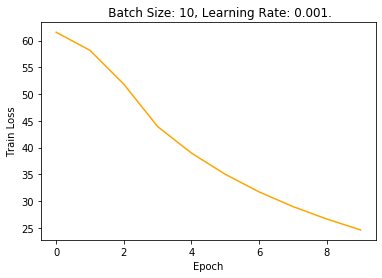

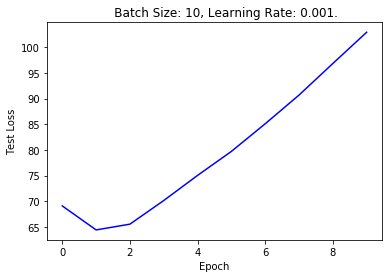

In [153]:
plot(Costs[0], 10, str(0.001), 'orange')
plot(Costs[1], 10, str(0.001), 'blue')

* **There is obviously an overfit.**
### Let's change the learning rate and filter numbers to change this situation:
***

In [156]:
Costs3 = CNNModel(1, [12], [3], 0.0005)

Epoch:  0 	Test Correct:  7 	Test Loss:  4499.316502094269
Epoch:  0 	Train Correct:  491 	Train Loss:  16952.523940563202
Epoch:  1 	Test Correct:  110 	Test Loss:  4185.173414230347
Epoch:  1 	Train Correct:  574 	Train Loss:  16003.217898368835
Epoch:  2 	Test Correct:  101 	Test Loss:  4205.807156562805
Epoch:  2 	Train Correct:  1342 	Train Loss:  14460.731867074966
Epoch:  3 	Test Correct:  101 	Test Loss:  4313.037302494049
Epoch:  3 	Train Correct:  5243 	Train Loss:  11993.797260284424
Epoch:  4 	Test Correct:  84 	Test Loss:  4519.487265586853
Epoch:  4 	Train Correct:  8359 	Train Loss:  10086.226264357567
Epoch:  5 	Test Correct:  65 	Test Loss:  4764.6599197387695
Epoch:  5 	Train Correct:  11053 	Train Loss:  8552.762924313545
Epoch:  6 	Test Correct:  55 	Test Loss:  5058.596551418304
Epoch:  6 	Train Correct:  13201 	Train Loss:  7269.046713382006
Epoch:  7 	Test Correct:  51 	Test Loss:  5400.499565124512
Epoch:  7 	Train Correct:  15043 	Train Loss:  6213.260844051838

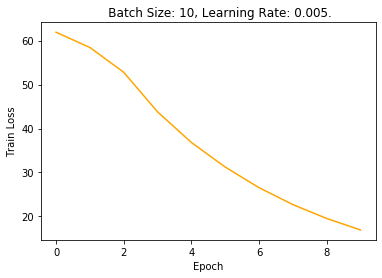

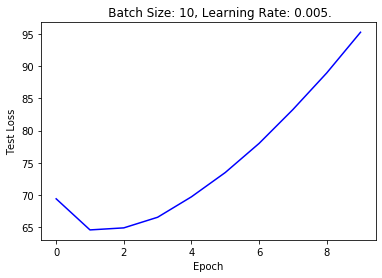

In [157]:
plot(Costs3[0], 10, str(0.005), 'orange')
plot(Costs3[1], 10, str(0.005), 'blue')

* **We still can't prevent overfitting.** 
* **This occurs because the dataset is noisy, it has too many classes with too few instances and training it succesfully is difficult.**

***
### Finally, let's try with a 2-layer CNN.
### Input -> Conv1 -> ReLU -> MaxPool(2) -> Conv2 -> ReLU -> MaxPool(2) -> FC1 -> ReLU -> Output

In [152]:
Costs2 = CNNModel(2, [4, 8], [3, 3], 0.001)

Epoch:  0 	Test Correct:  8 	Test Loss:  4467.770988941193
Epoch:  0 	Train Correct:  496 	Train Loss:  16771.725048065186
Epoch:  1 	Test Correct:  121 	Test Loss:  4160.058896064758
Epoch:  1 	Train Correct:  508 	Train Loss:  16619.620559692383
Epoch:  2 	Test Correct:  121 	Test Loss:  4158.514805316925
Epoch:  2 	Train Correct:  521 	Train Loss:  16614.031011104584
Epoch:  3 	Test Correct:  121 	Test Loss:  4158.738823413849
Epoch:  3 	Train Correct:  517 	Train Loss:  16595.129398822784
Epoch:  4 	Test Correct:  121 	Test Loss:  4158.714196205139
Epoch:  4 	Train Correct:  525 	Train Loss:  16581.116263389587
Epoch:  5 	Test Correct:  124 	Test Loss:  4159.638205051422
Epoch:  5 	Train Correct:  515 	Train Loss:  16552.379406929016
Epoch:  6 	Test Correct:  129 	Test Loss:  4170.136677265167
Epoch:  6 	Train Correct:  510 	Train Loss:  16534.431879997253
Epoch:  7 	Test Correct:  115 	Test Loss:  4195.900575637817
Epoch:  7 	Train Correct:  510 	Train Loss:  16530.476702213287
Ep

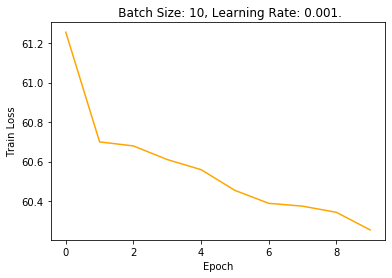

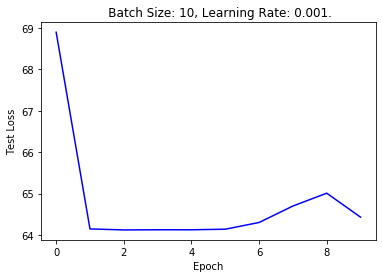

In [154]:
plot(Costs2[0], 10, str(0.001), 'orange')
plot(Costs2[1], 10, str(0.001), 'blue')

* **Changing the layer numbers did not work.**

# FINAL CONCLUSION
## Neural Network:
* Dataset contains **34225 images and 683 classes**.
* **For every class**, approximately **50 images.**
* This number is **not enough for training** the neural network.
* In this notebook, **30 different combinations of Neural Networks** have been **trained.**
* None of them was successful, due to the dataset.
* Increasing Train Accuracy caused Test Loss.
* Making **few epochs** caused **underfit.**
* Making **more epochs** caused **overfit.**
* **Incrementing learning rate** caused **overfit.**
* **Decrementing learning rate** caused **slow converge.**
* The **only useful** activation functions were **'ReLU'** and **'Softmax'.**
* The Train **Accuracy** of NN **was about 18-20%.**
* The Test **Accuracy** of NN **was about 4%.**
* These values are not good, compared to CNN..
****
## Convolutional Neural Network:
* Since the **CNN Training takes much longer time** than a NN, the total **number of cases is smaller.(3)**
* **CNN was more successful** and better **compared to the Neural Network**, because **it applies different filters** and **different pooling methods** to modify the images and **take new and more useful features** about them.
* **These features, learning rates, batch sizes** were again **dynamic** and 3 different combinations of them have been tried.
* **Using more filters caused overfit.**
* **Using less filters caused underfit.**
* The Train **Accuracy** of CNN **was about 66%.**
* The Test **Accuracy** of CNN **was about 10%.**
* These values can be considered good, assuming the insufficiency of the dataset.